In [2]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [3]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 - Population Growth Rate

In [5]:
q1_sql= """

SELECT 
    year,
    pop,
    LAG(pop) OVER (ORDER BY year) AS prev_pop,
    ROUND(
        (pop - LAG(pop) OVER (ORDER BY year))::numeric 
        / NULLIF(LAG(pop) OVER (ORDER BY year), 0) * 100, 
        2
    ) AS growth_rate_percent
FROM population
WHERE fips = '47'   
ORDER BY year ASC;



"""


In [21]:
import pandas as pd

va_df = pd.read_sql(q1_sql, con=conn)
va_df.head(15) #show the top 5 rows

/tmp/ipykernel_7829/2157594293.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  va_df = pd.read_sql(q1_sql, con=conn)


,year,pop,prev_pop,growth_rate_percent
0,2005,5810590,NaN,NaN
1,2006,6038803,5810590.0,3.93
2,2007,6156719,6038803.0,1.95
3,2008,6214888,6156719.0,0.94
4,2009,6296254,6214888.0,1.31
5,2010,6356897,6296254.0,0.96
6,2011,6403353,6356897.0,0.73
7,2012,6456243,6403353.0,0.83
8,2013,6495978,6456243.0,0.62
9,2014,6549352,6495978.0,0.82


,year,population,prev_pop,growth_rate_percent
0,2005,5810590,NaN,NaN
1,2006,6038803,5810590.0,3.93
2,2007,6156719,6038803.0,1.95
3,2008,6214888,6156719.0,0.94
4,2009,6296254,6214888.0,1.31
5,2010,6356897,6296254.0,0.96
6,2011,6403353,6356897.0,0.73
7,2012,6456243,6403353.0,0.83
8,2013,6495978,6456243.0,0.62
9,2014,6549352,6495978.0,0.82


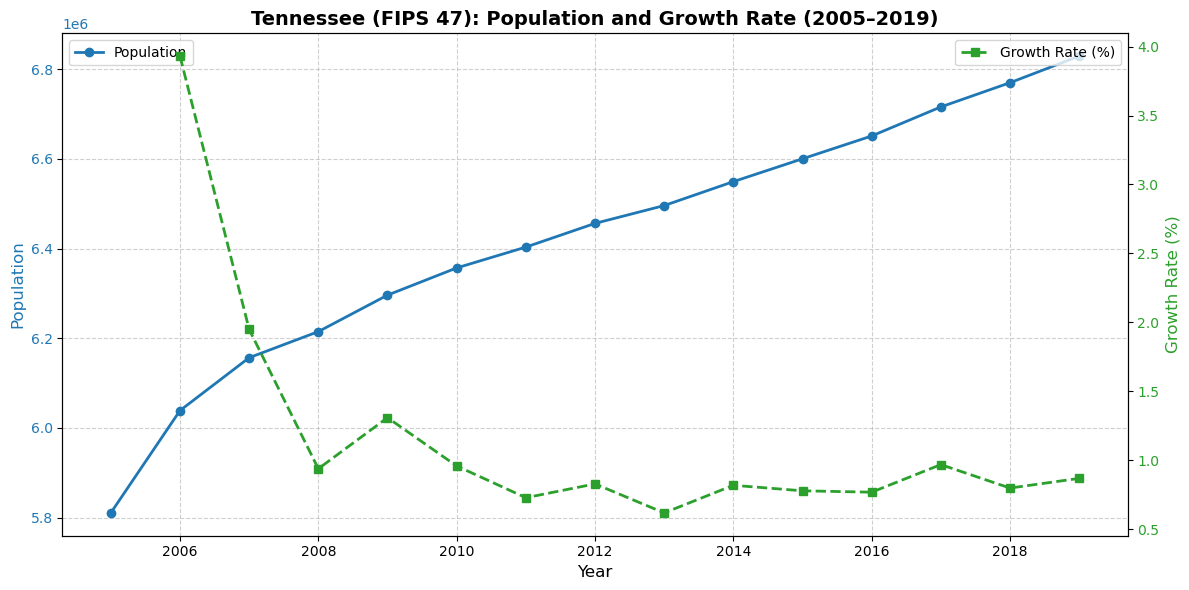

In [22]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create a DataFrame with the new SQL output
data = {
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
             2015, 2016, 2017, 2018, 2019],
    'population': [5810590, 6038803, 6156719, 6214888, 6296254, 6356897, 
                   6403353, 6456243, 6495978, 6549352, 6600299, 6651194, 
                   6715984, 6770010, 6829174],
    'prev_pop': [None, 5810590, 6038803, 6156719, 6214888, 6296254,
                 6356897, 6403353, 6456243, 6495978, 6549352, 6600299,
                 6651194, 6715984, 6770010],
    'growth_rate_percent': [None, 3.93, 1.95, 0.94, 1.31, 0.96, 0.73, 0.83, 
                            0.62, 0.82, 0.78, 0.77, 0.97, 0.80, 0.87]
}

df = pd.DataFrame(data)

# Step 2: Display the DataFrame for validation
display(df)

# Step 3: Create a dual-axis chart (Population and Growth Rate)
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Primary Axis: Population (absolute values) ---
color_pop = 'tab:blue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Population', color=color_pop, fontsize=12)
ax1.plot(df['year'], df['population'], color=color_pop, marker='o', linewidth=2, label='Population')
ax1.tick_params(axis='y', labelcolor=color_pop)
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Secondary Axis: Growth Rate (percentage) ---
ax2 = ax1.twinx()
color_growth = 'tab:green'
ax2.set_ylabel('Growth Rate (%)', color=color_growth, fontsize=12)
ax2.plot(df['year'], df['growth_rate_percent'], color=color_growth, marker='s', linestyle='--',
         linewidth=2, label='Growth Rate (%)')
ax2.tick_params(axis='y', labelcolor=color_growth)

# Step 4: Title and Formatting
plt.title('Tennessee (FIPS 47): Population and Growth Rate (2005–2019)', fontsize=14, weight='bold')
fig.tight_layout()

# Step 5: Add Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Step 6: Display Visualization
plt.show()


- The Tennessee growth rate has continually dropped from 2005 - 2019 with it reaching a relatively stable level at roughly 5.9% per year.

## Q2 - Population Median Income

In [8]:
q2_sql= """

SELECT 
    p.year,
    p.pop AS population,
    i.income AS median_income
FROM population p
JOIN income i
    ON p.fips = i.fips
   AND p.year = i.year
WHERE p.fips = '47'
ORDER BY p.year ASC;

"""

In [18]:
import pandas as pd

va_df = pd.read_sql(q2_sql, con=conn)
va_df.head(15) #show the top 5 rows

/tmp/ipykernel_7829/3952025345.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  va_df = pd.read_sql(q2_sql, con=conn)


,year,population,median_income
0,2005,5810590,38874
1,2006,6038803,40315
2,2007,6156719,42367
3,2008,6214888,43614
4,2009,6296254,41725
5,2010,6356897,41461
6,2011,6403353,41693
7,2012,6456243,42764
8,2013,6495978,44297
9,2014,6549352,44361


,year,population,median_income
0,2005,5810590,38874
1,2006,6038803,40315
2,2007,6156719,42367
3,2008,6214888,43614
4,2009,6296254,41725
5,2010,6356897,41461
6,2011,6403353,41693
7,2012,6456243,42764
8,2013,6495978,44297
9,2014,6549352,44361


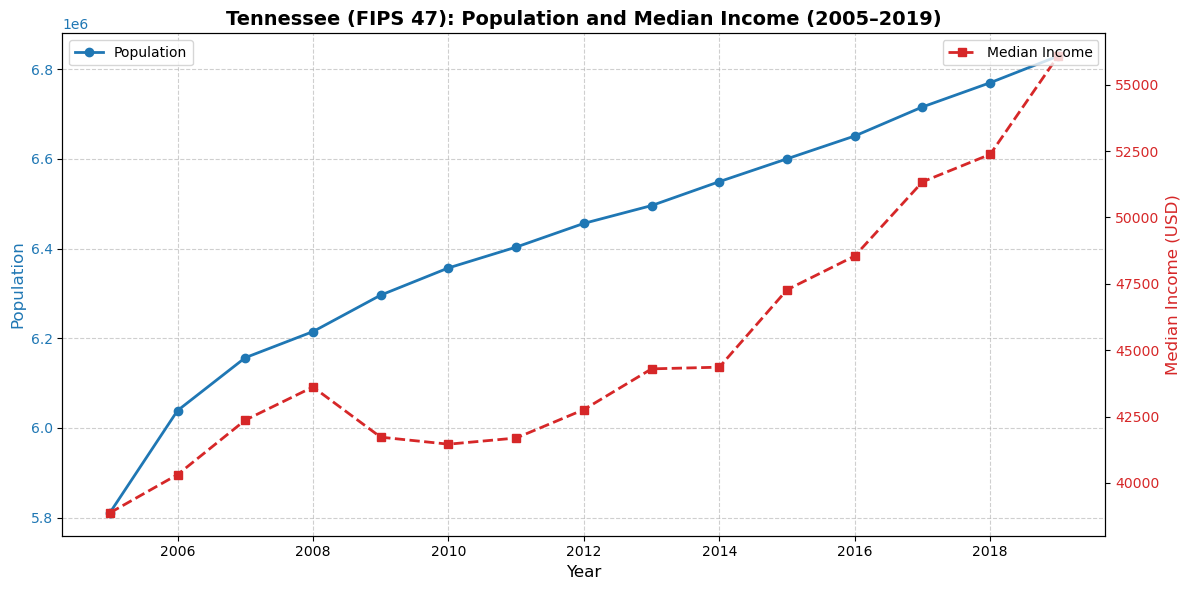

In [19]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Construct the DataFrame from the updated SQL output
data = {
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
             2015, 2016, 2017, 2018, 2019],
    'population': [5810590, 6038803, 6156719, 6214888, 6296254, 6356897,
                   6403353, 6456243, 6495978, 6549352, 6600299, 6651194,
                   6715984, 6770010, 6829174],
    'median_income': [38874, 40315, 42367, 43614, 41725, 41461, 41693, 42764,
                      44297, 44361, 47275, 48547, 51340, 52375, 56071]
}

df = pd.DataFrame(data)

# Step 2: Display the DataFrame to confirm structure
display(df)

# Step 3: Create a dual-axis plot (Population and Median Income)
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Left Y-Axis: Population ---
color_pop = 'tab:blue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Population', color=color_pop, fontsize=12)
ax1.plot(df['year'], df['population'], color=color_pop, marker='o', linewidth=2, label='Population')
ax1.tick_params(axis='y', labelcolor=color_pop)
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Right Y-Axis: Median Income ---
ax2 = ax1.twinx()
color_income = 'tab:red'
ax2.set_ylabel('Median Income (USD)', color=color_income, fontsize=12)
ax2.plot(df['year'], df['median_income'], color=color_income, marker='s', linewidth=2, linestyle='--', label='Median Income')
ax2.tick_params(axis='y', labelcolor=color_income)

# Step 4: Add Title and Formatting
plt.title('Tennessee (FIPS 47): Population and Median Income (2005–2019)', fontsize=14, weight='bold')
fig.tight_layout()

# Step 5: Add Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Step 6: Display the Visualization
plt.show()


- The median income of Tennessee stagnated from 2008 to 2014, however it recovered and saw increased growth from 2014 until 2019.

## Q3 - Population Change

In [23]:
q3_sql= """

SELECT 
    p.year,
    p.pop AS population,
    LAG(p.pop) OVER (ORDER BY p.year) AS prev_population,
    (p.pop - LAG(p.pop) OVER (ORDER BY p.year)) AS population_change
FROM population p
WHERE p.fips = '47'
  AND p.year BETWEEN 2005 AND 2019
ORDER BY p.year ASC;

"""

In [24]:
import pandas as pd

va_df = pd.read_sql(q3_sql, con=conn)
va_df.head(15) #show the top 5 rows

/tmp/ipykernel_7829/3037383276.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  va_df = pd.read_sql(q3_sql, con=conn)


,year,population,prev_population,population_change
0,2005,5810590,NaN,NaN
1,2006,6038803,5810590.0,228213.0
2,2007,6156719,6038803.0,117916.0
3,2008,6214888,6156719.0,58169.0
4,2009,6296254,6214888.0,81366.0
5,2010,6356897,6296254.0,60643.0
6,2011,6403353,6356897.0,46456.0
7,2012,6456243,6403353.0,52890.0
8,2013,6495978,6456243.0,39735.0
9,2014,6549352,6495978.0,53374.0


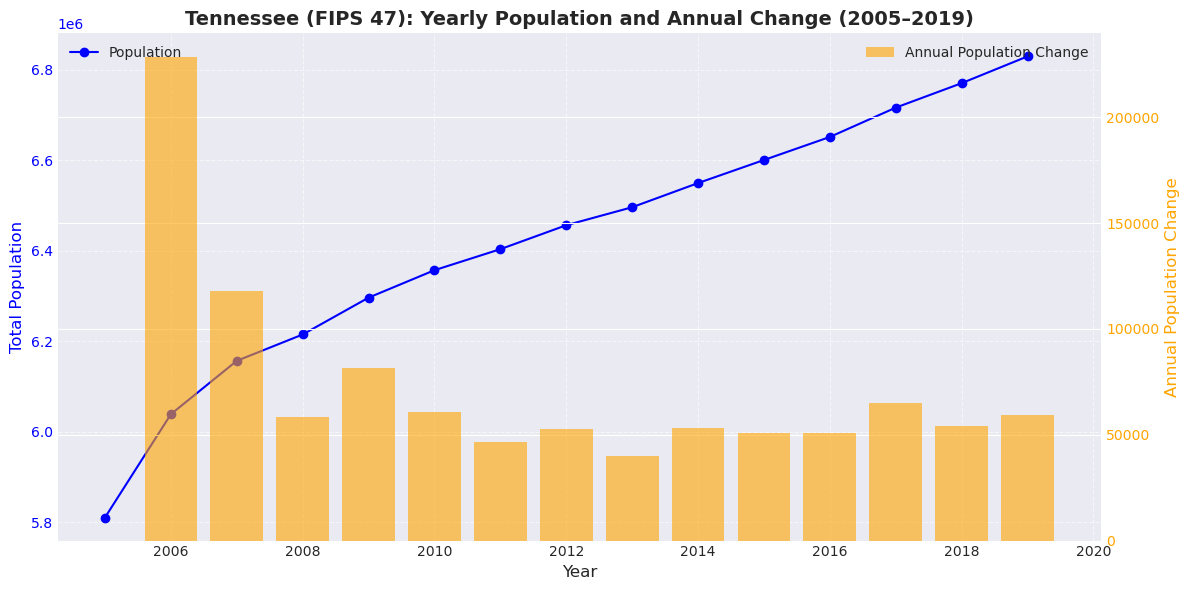

In [25]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame using the given data
data = {
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 
             2015, 2016, 2017, 2018, 2019],
    'population': [5810590, 6038803, 6156719, 6214888, 6296254, 6356897, 6403353, 
                   6456243, 6495978, 6549352, 6600299, 6651194, 6715984, 6770010, 6829174],
    'prev_population': [None, 5810590, 6038803, 6156719, 6214888, 6296254, 6356897, 
                        6403353, 6456243, 6495978, 6549352, 6600299, 6651194, 6715984, 6770010],
    'population_change': [None, 228213, 117916, 58169, 81366, 60643, 46456, 52890, 
                          39735, 53374, 50947, 50895, 64790, 54026, 59164]
}

df = pd.DataFrame(data)

# Set a clean style
plt.style.use('seaborn-v0_8-darkgrid')

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot population (left y-axis)
ax1.plot(df['year'], df['population'], color='blue', marker='o', label='Population')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Population', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for population change
ax2 = ax1.twinx()
ax2.bar(df['year'], df['population_change'], color='orange', alpha=0.6, label='Annual Population Change')
ax2.set_ylabel('Annual Population Change', color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title and improve layout
plt.title('Tennessee (FIPS 47): Yearly Population and Annual Change (2005–2019)', fontsize=14, fontweight='bold')

# Add grid and legend
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Tight layout for aesthetics
plt.tight_layout()

# Display the plot
plt.show()


- This graph shows the growth of Tennesse's population by the number of people instead of percent growth rate. The graph shows 2006 showed the largest growth of population in Tennesse.